# HW 15
## James Camacho

This is the 12th homework assignment, but we're skipping a few numbers to keep it the same as the lecture number.


We just put together our previous code, but with the deferred correction finite difference method.

In [5]:
import numpy as np
from scipy.special import jv
import scipy.sparse

j0 = lambda kr: jv(0, kr)

k = 20

def f(x, y):
    return (k**2 - 1)*(np.cos(x) + np.sin(y))

def laplace_f(x, y):
    return -f(x, y)

def u_exact(x, y):
    return j0(k*np.sqrt(x**2+y**2)) + np.cos(x) + np.sin(y)

def bdry(x, y, N):
    xi = np.linspace(0, 1, N)
    if x == None:
        return u_exact(xi, y)
    if y == None:
        return u_exact(x, xi)
    
    raise("Bad input. Example of good input: (None, 0) = along x axis with y=0.")

def add_boundaries(u, N):
    u = np.pad(u, pad_width=1, mode='empty').T
    u[0, :] = bdry(0, None, N)
    u[-1,:] = bdry(1, None, N)
    u[:, 0] = bdry(None, 0, N)
    u[:,-1] = bdry(None, 1, N)
    return u.T

def u_xxyy(u, n):
    u = add_boundaries(u, n+2)
    return ((u[2:, 2:] + u[2:, :-2] + u[:-2, 2:] + u[:-2, :-2]) -
                   2*(u[2:,1:-1] + u[:-2,1:-1] + u[1:-1,2:] + u[1:-1,:-2]) +
                   4*u[1:-1,1:-1]) * (n+1)**4

def f_bdry(x, y, n):
    xi = np.linspace(0, 1, n+2)
    if x == None:
        v = u_exact(xi, y)
    elif y == None:
        v = u_exact(x, xi)
    else:
        raise Exception("Bad input. Example of good input: (None, 0) = along x axis with y=0.")
    return v[1:-1] * (n+1)**2

def get_F(n):
    xi = np.linspace(0, 1, n+2)[1:-1]
    x, y = np.meshgrid(xi, xi)
    F = f(x, y)
    F = F.reshape((n, n)).T
    
    # Subtract off Dirichlet boundaries
    F[0, :] -= f_bdry(0, None, n)
    F[-1, :] -= f_bdry(1, None, n)
    F[:, 0] -= f_bdry(None, 0, n)
    F[:, -1] -= f_bdry(None, 1, n)
    
    return F.T.flatten()

def get_A(n):
    # Five point stencil for Laplacian
    
    d0 = np.full(n**2, k**2 - 4*(n+1)**2)
    d1 = ([(n+1)**2]*(n-1) + [0])*n # left/right
    d2 = np.full(n**2, (n+1)**2) # up/down
    diags = [d0, d1, d1, d2, d2]
    offsets = [0, 1, -1, n, -n]
    A = scipy.sparse.diags(diags, offsets)
    return A

def get_f_correction(n):
    xi = np.linspace(0, 1, n+2)[1:-1]
    x, y = np.meshgrid(xi, xi)
    
    F = f(x, y).reshape((n, n))
    df = (-1-k**2)*F
    
    return df.flatten()

def get_correction(u, n):
    df = get_f_correction(n).reshape((n, n))
    
    u = u.reshape((n, n))
    dg = (k**4*u - 2*u_xxyy(u, n))
    
    return (df + dg).flatten()

def solve_helmholtz(n, max_iters=1, error=1e-10):
    A = get_A(n)
    F = get_F(n)
    u = scipy.sparse.linalg.spsolve(A, F)
    
    for i in range(max_iters):
        G = F + 1 / 12 / (n+1)**2 * get_correction(u, n)
        u = scipy.sparse.linalg.spsolve(A, G)
    
    return u

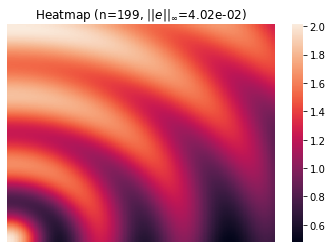

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

n = 199

u = solve_helmholtz(n)
u = u.reshape((n, n))
u = add_boundaries(u, n+2)

x = y = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(x, y)
ux = u_exact(xx, yy).reshape((n+2, n+2))
error = np.linalg.norm((u-ux).flatten())

plt.title(f"Heatmap (n={n}, "+r"$||e||_{\infty}$"+f"={error:.2e})")
ax = sns.heatmap(u)
ax.invert_yaxis()
plt.axis('off')
plt.show();

We compute the error for $n = 99, 199, 299, 399, 499$ ($h=1/100,1/200,1/300,1/400,1/500$) and find the convergence rate.

In [7]:
hs = []
errors = []
for n in [99, 199, 299, 399, 499]:
    h = 1/(n+1)
    hs.append(h)
    u = solve_helmholtz(n)
    u = u.reshape((n, n))
    u = add_boundaries(u, n+2)

    x = y = np.linspace(0, 1, n+2)
    xx, yy = np.meshgrid(x, y)
    ux = u_exact(xx, yy).reshape((n+2, n+2))
    error = np.linalg.norm((u-ux).flatten(), ord=np.inf)
    
    errors.append(error)
    print(h, error)

0.01 0.011542749199821456
0.005 0.0006375946436533164
0.0033333333333333335 0.00012435306827307535
0.0025 3.920829016634819e-05
0.002 1.603392978433149e-05


Slope: 4.085825067760074


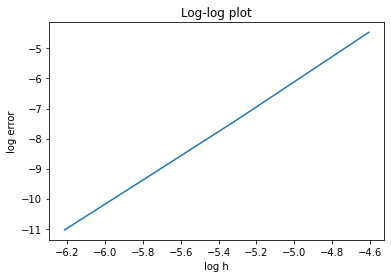

In [8]:
log_h = np.log(hs)
log_e = np.log(errors)
plt.plot(log_h, log_e)
plt.title("Log-log plot")
plt.xlabel("log h")
plt.ylabel("log error")

slope, _ = np.polyfit(log_h, log_e, deg=1)
print("Slope:", slope)

As you can see it's 4th order accurate.